In [2]:
#import gsw
import scipy.io as sio
import scipy.signal as signal
from scipy import stats
import scipy as sc
import matplotlib.pyplot 
import numpy as np
import datetime as dt
import matplotlib.dates as mdates #import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#import cmocean as cm
import matplotlib.colors as mcolors
import functions_copy as functions 
#%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 150
#plt.rcParams['figure.figsize'] = [9,6]
#plt.rcParams['figure.dpi'] = 150
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import cmocean as cm
import ttide as tt
import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
import spectrum

#from scipy import signal, ndimage
#from scipy import fft as spfft
import scipy.fft as sf 


## Define functions, that will be used later

In [3]:
#define functions to return the Coriolis and tidal frequqncies
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Args: 
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return np.abs(2*np.sin(lat*2*np.pi/360)*omega*(3600)*24)

def tidefreq():
    """
    Eight major tidal frequencies in rad / day.  See Gill (1982) page 335.
    
    Args: 
        None
        
    Returns:
        An array of eight frequencies
    """    
    return 24*2*np.pi/np.array([327.85,25.8194,24.0659,23.9344,12.6584,12.4206,12.0000,11.9673])

def variance_ellipse(u,v):
    """
    Compute parameters of the variance ellipse.
    
    Args: 
        u: 1-D array of eastward velocities (or real part of complex variable)
        v: 1-D array of northward velocities (or imaginary part of complex variable)
            
    Returns:
        a: semi-major axis 
        b: semi-minor axis 
        theta: orientation angle counterclockwise from x axis, in radians
    """
    
    #compute terms in the covariance matrix
    cuu=np.mean(np.multiply(u-np.mean(u),u-np.mean(u)))
    cvv=np.mean(np.multiply(v-np.mean(v),v-np.mean(v)))
    cuv=np.mean(np.multiply(u-np.mean(u),v-np.mean(v)))
    
    detc=np.real(cuu*cvv-cuv**2) #determinant of covariance matrix
    trc=cuu+cvv #trace of covariance matrix

    a=np.sqrt(trc/2+np.sqrt(trc**2-4*detc)/2)#semi-major axis
    b=np.sqrt(trc/2-np.sqrt(trc**2-4*detc)/2)#semi-minor axis
    theta=np.arctan2(2*cuv,cuu-cvv)/2#orientation angle
    
    return a,b,theta

#now we add a plot of the variance ellipse
def plot_ellipse(a,b,theta,center=(0,0),color=(0.5,0.5,0.5),linewidth=3,outline="w",aspect=1,transform=False):
    """
    Plot an ellipse.
    
    Args: 
        a: Ellipse semi-major axis
        b: Ellipse semi-minor axis
        theta: Ellipse orientation angle in radians    
        
    Optional Args:
        center: The ellipse center, a complex number or 2-tuple; defaults to (0,0)
        color: Ellipse line color, a 3-tuple; defaults to (0.5,0.5,0.5)
        linewidth: Ellipse line width; defaults to 3
        outline: Color for an outline around the ellipse; defaults to "w"
        aspect: Aspect ratio by which to adjust the ellipse; defaults to one
        transform: Coordinate transform to apply for use with Cartopy; defaults to none

    Returns:
        h: Handle to ellipse object
        z: Array of complex numbers describing the ellipse periphery 
    """
    phi=np.arange(0,2*np.pi+.1,.1)

    if isinstance(center,complex):
        x=center.real
        y=center.imag
    else:
        x=center[0];
        y=center[1];
  
    z=np.exp(1j*theta)*(a*np.cos(phi)-1j*b*np.sin(phi))
    ax = plt.gca()
    
    if not(transform):
        ax.plot(np.real(z)+x,(1/aspect)*np.imag(z)+y,linewidth=linewidth*1.5,color=outline)
        h=ax.plot(np.real(z)+x,(1/aspect)*np.imag(z)+y,linewidth=linewidth,color=color)
    else:
        ax.plot(np.real(z)+x,(1/aspect)*np.imag(z)+y,linewidth=linewidth*1.5,color=outline,transform=transform)
        h=ax.plot(np.real(z)+x,(1/aspect)*np.imag(z)+y,linewidth=linewidth,color=color,transform=transform)
    
    return h,z

# Load the mooring arrays

##### Load the data from the northern mooring array

In [4]:
file_path = "/media/sf_VM_Folder/data/moorings/supermooring.mat"

In [5]:
struct = sio.loadmat(file_path)

In [6]:
data = struct["mooring"]
data.dtype

dtype([('INSTITUTE', 'O'), ('INST_COUNTRY', 'O'), ('MOORINGID', 'O'), ('LAT', 'O'), ('LON', 'O'), ('WATERDEPTH', 'O'), ('CRUISE', 'O'), ('LEG', 'O'), ('SHIP', 'O'), ('INSTRUMENTTYPE', 'O'), ('SN', 'O'), ('STARTDATE', 'O'), ('INSTRUMENTDEPTH', 'O'), ('DATETIME', 'O'), ('DEPTH', 'O'), ('PRES', 'O'), ('TEMP', 'O'), ('SALT', 'O'), ('SPD', 'O'), ('DIR', 'O'), ('UC', 'O'), ('VC', 'O'), ('SA', 'O'), ('CT', 'O'), ('potemp', 'O'), ('potdens', 'O'), ('gamma_n', 'O')])

In [7]:
#load necessary data into usable variables
lat_list = np.squeeze(data["LAT"])
lon_list = np.squeeze(data["LON"])
depth_list = np.squeeze(data["DEPTH"])
pressure_list = np.squeeze(data["PRES"])

u_list = np.squeeze(data["UC"])
v_list = np.squeeze(data["VC"])
SA_list = np.squeeze(data["SA"])
Temp_list = np.squeeze(data["TEMP"])

#Convert matlab time arrays to arrays filled with python datetime objects
time_list = []
for i in range(lat_list.size):
    mtime = np.squeeze(data["DATETIME"])[i]
    time_list.append([functions.matlab2datetime(tval) for tval in mtime.flatten().tolist()])
time_list = np.asarray(time_list)

##### Load the data from the southern mooring array

In [8]:
file_path = "/media/sf_VM_Folder/data/moorings/AQD76S_2018_2021.mat"

In [9]:
struct = sio.loadmat(file_path)

In [10]:
data = struct["A"]
data.dtype

dtype([('info', 'O'), ('Mooring', 'O'), ('lat', 'O'), ('lon', 'O'), ('WaterDep', 'O'), ('SN', 'O'), ('SN_head', 'O'), ('time', 'O'), ('error_code', 'O'), ('status_code', 'O'), ('beam_x', 'O'), ('beam_y', 'O'), ('beam_z', 'O'), ('amp', 'O'), ('batt_volt', 'O'), ('sound_speed', 'O'), ('sound_speed_used', 'O'), ('heading', 'O'), ('pitch', 'O'), ('roll', 'O'), ('pre', 'O'), ('dep', 'O'), ('tem', 'O'), ('analog_input', 'O'), ('spd', 'O'), ('dir', 'O'), ('transf_u', 'O'), ('transf_v', 'O'), ('transf_w', 'O')])

In [11]:
#load necessary data into usable variables
slat_list = -1*np.squeeze(data["lat"])
slon_list = -1*np.squeeze(data["lon"])
sdepth_list = np.squeeze(data["dep"])
#pressure_list = np.squeeze(data["PRES"])

su_list = np.squeeze(data["transf_u"])
sv_list = np.squeeze(data["transf_v"])
#SA_list = np.squeeze(data["SA"])
sTemp_list = np.squeeze(data["tem"])

#Convert matlab time arrays to arrays filled with python datetime objects
stime_list = []
for i in range(slat_list.size):
    mtime = np.squeeze(data["time"])[i]
    stime_list.append([functions.matlab2datetime(tval) for tval in mtime.flatten().tolist()])
stime_list = np.asarray(stime_list)

In [12]:
for i,j in zip(slat_list,slon_list):
    print(i,j)

[[-75.96183333]] [[-31.482]]
[[-76.04583333]] [[-30.99416667]]
[[-76.04583333]] [[-30.99416667]]
[[-76.09116667]] [[-30.46983333]]
[[-76.09116667]] [[-30.46983333]]


# Select time series from Northern moorings

In [13]:
ntime = time_list[53]
nu = np.squeeze(u_list[53])
nv = np.squeeze(v_list[53])
nlat = 1 * np.squeeze(lat_list[53])
nlon = 1 * np.squeeze(lon_list[53])
ndepth = np.mean(np.squeeze(depth_list[53]))
print(ndepth, nlat)

#if velocities are too high, convert to m/s instead of cm/s
#if max(abs(u))>20 or max(abs(v))>20:
#u = u/100
#v = v/100


if np.any(np.isnan(nu)):
    trim_index = np.argmax(np.isnan(nu))
    nu = nu[:trim_index]
    nv = nv[:trim_index]
    ntime = ntime[:trim_index]
    
ncv = nu + 1j * nv

print(np.mean(np.abs(ncv)))

1624.943406093679 -63.5145
28.891485506441118


In [14]:
errcalc = "wboot"
out  = tt.t_tide(xin = ncv, dt = 2, out_style = None, lat = nlat, errcalc = errcalc)
tidal_uv = out["xout"]

# Select time series from Southern moorings

In [15]:
stime = stime_list[0]
su = np.squeeze(su_list[0])
sv = np.squeeze(sv_list[0])
slat = 1 * np.squeeze(slat_list[0])
slon = 1 * np.squeeze(slon_list[0])
sdepth = np.mean(np.squeeze(sdepth_list[0]))
print(ndepth, nlat)

#if velocities are too high, convert to m/s instead of cm/s
#if max(abs(u))>20 or max(abs(v))>20:
#u = u/100
#v = v/100

"""
if np.any(np.isnan(nu)):
    trim_index = np.argmax(np.isnan(nu))
    su = nu[:trim_index]
    nv = nv[:trim_index]
    ntime = ntime[:trim_index]
"""

scv = su *100 + 1j * sv * 100

1624.943406093679 -63.5145


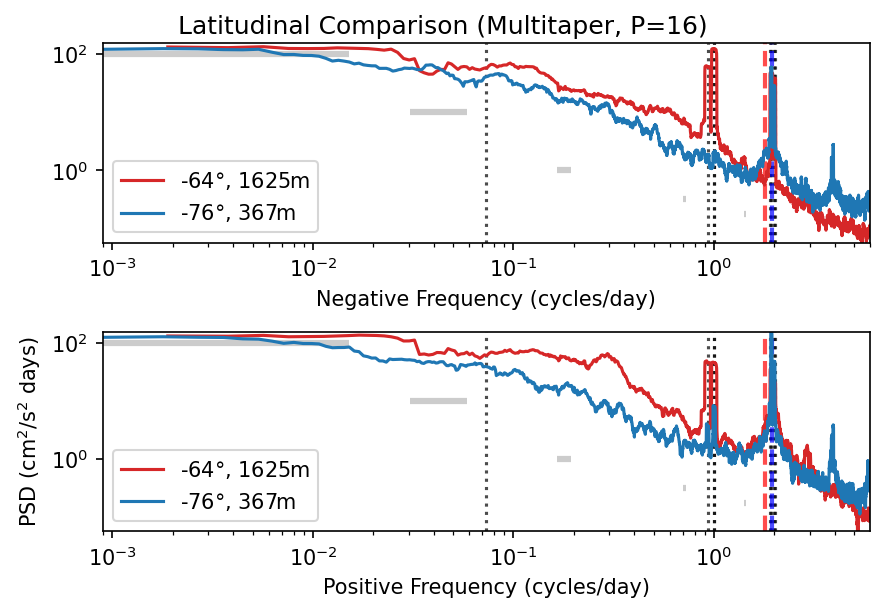

In [16]:
cvs = [ncv,scv]
labels = [f"{nlat:.0f}$\degree$, {ndepth:.0f}m",f"{slat:.0f}$\degree$, {sdepth:.0f}m"]
dt = 2/24
colors = ["tab:red","tab:blue"]

fig, ax = plt.subplots(2, 1,sharey=True, figsize=(6,4))
    
for i,cv in enumerate(cvs):
    
    cv = cv[~np.isnan(cv)] #remove 
    
    f, _S = sg.periodogram(cv-np.mean(cv), fs=1/dt) #fs = sampling frequency (cyclic)
    
    P = 16
    psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2*P-1)

    Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  

    #print(np.all(np.isnan(cv)))
    
    ax[0].loglog(-f[np.where(f<0)],S[np.where(f<0)], label = labels[i], color = colors[i])#plot negative side
    ax[0].invert_xaxis()
    ax[1].set_ylabel('PSD (cm$^2$/s$^2$ days)')
    ax[0].set_xlabel('Negative Frequency (cycles/day)')

    ax[1].loglog( f[np.where(f>0)],S[np.where(f>0)], label = labels[i], color = colors[i])#plot positive side
    ax[1].autoscale(enable=True, tight=True)
    #ax[1].set_ylim(1e-1, 1e3) 
    #ax[0].set_xlim(8, 0.2*1e-3)
    #ax[0].set_xlim(0.2*1e-3, 8)
    ax[1].set_xlabel('Positive Frequency (cycles/day)')

ax[0].legend()   
ax[1].legend() 

for n in range(np.size(ax)):
    ax[n].autoscale(enable=True, tight=True)
    ax[n].vlines(tidefreq()/2/np.pi,ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle=":", color="black", alpha = 0.7)
    ax[n].vlines(corfreq(nlat)/2/np.pi,ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle="--", color="r",linewidth=2, alpha = 0.7)
    ax[n].vlines(corfreq(slat)/2/np.pi,ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle="--", color="b",linewidth=2, alpha = 0.7)

    io=(1,50,200,800,1600)
    yo=(10**2,10**1,10**0,10**(-0.5),10**(-0.75))
    
    plt.sca(ax[n])
    for i in range(np.size(io)):
        if i==0:
            plt.hlines(yo[i],f[io[i]],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)
        else:
            plt.hlines(yo[i],f[io[i]-P],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)      
   

fig.tight_layout()
fig.suptitle('Latitudinal Comparison (Multitaper, P=16)', y=1.01);

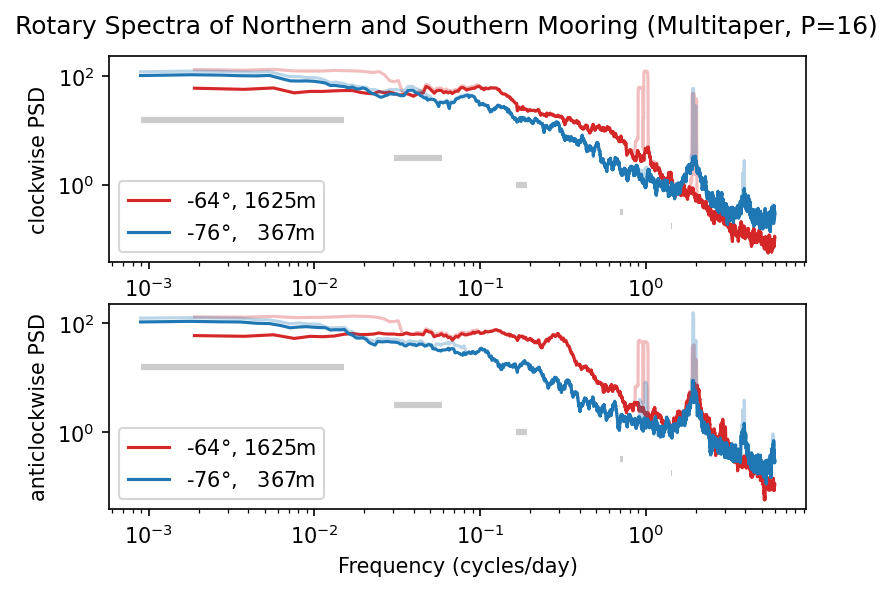

In [17]:
cvs = [ncv,scv]
lats = [nlat,slat]
labels = [f"{nlat:.0f}$\degree$, {ndepth:.0f}m",f"{slat:.0f}$\degree$,   {sdepth:.0f}m"]
colors = ["tab:red","tab:blue"]
dt = 2/24
fig, ax = plt.subplots(2, 1,sharey=True, figsize=(6,4))
    
for i,cv in enumerate(cvs):
    
    cv = cv[~np.isnan(cv)] #remove 
    ccv = cv
        
    errcalc = "wboot"
    out  = tt.t_tide(xin = cv, dt = 2, out_style = None, lat = lats[i], errcalc = errcalc)
    tidal_uv = out["xout"]

    #remove tidal peaks
    cv = cv - tidal_uv.squeeze()
    
    tf, _tS = sg.periodogram(cv-np.mean(cv), fs=1/dt) #fs = sampling frequency (cyclic)

    f, _S = sg.periodogram(cv-np.mean(cv), fs=1/dt) #fs = sampling frequency (cyclic)
    
    P = 16
    psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2*P-1)

    Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  

    #print(np.all(np.isnan(cv)))
    
    ax[0].loglog(-f[np.where(f<0)],S[np.where(f<0)], label = labels[i], color = colors[i])#plot negative side
    ax[0].invert_xaxis()
    ax[0].set_ylabel('clockwise PSD')
    ax[1].set_ylabel('anticlockwise PSD')
    #ax[0].set_xlabel('Frequency (cycles/day)')

    ax[1].loglog( f[np.where(f>0)],S[np.where(f>0)], label = labels[i], color = colors[i])#plot positive side
    ax[1].autoscale(enable=True, tight=True)
    #ax[1].set_ylim(1e-1, 1e3) 
    #ax[0].set_xlim(8, 0.2*1e-3)
    #ax[0].set_xlim(0.8, 8)
    ax[1].set_xlim(ax[0].get_xlim())
    
    #ax[1].set_xlim(0.8, 8)
    ax[1].set_xlabel('Frequency (cycles/day)')

    
    #plot original time series
    Zk, weights, eigenvalues = spectrum.mtm.pmtm(ccv-np.mean(ccv), k=2*P-1,  NFFT=np.size(ccv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  
    ax[0].loglog(-f[np.where(f<0)],S[np.where(f<0)], color = colors[i], alpha = 0.3)
    ax[1].loglog(f[np.where(f>0)],S[np.where(f>0)], color = colors[i], alpha = 0.3)
    
ax[0].legend()   
ax[1].legend() 

for n in range(np.size(ax)):
    #ax[n].autoscale(enable=True, tight=True)
    #ax[n].vlines(tidefreq()/2/np.pi,ax[1].get_ylim()[0],ax[1].get_ylim()[1],linestyle=":", color="black", alpha = 0.7)
    #[ax[n].axvline(_x,linestyle=":", color="black", alpha = 0.5, zorder = -1) for _x in tidefreq()/2/np.pi]
    #ax[n].axvline(corfreq(nlat)/2/np.pi,linestyle="--", color="red",linewidth=2, alpha = 0.5, zorder = -1)
    #ax[n].axvline(corfreq(slat)/2/np.pi,linestyle="--", color="blue",linewidth=2, alpha = 0.5, zorder = -1)   
    
    io=(1,50,200,800,1600)
    yo=(10**1.2,10**0.5,10**0,10**(-0.5),10**(-0.75))
    
    plt.sca(ax[n])
    for i in range(np.size(io)):
        if i==0:
            plt.hlines(yo[i],f[io[i]],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)
        else:
            plt.hlines(yo[i],f[io[i]-P],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)      
           
        
#fig.tight_layout()
fig.suptitle("Rotary Spectra of Northern and Southern Mooring (Multitaper, P=16)", y=0.95);
plt.gcf().patch.set_facecolor('white')
#plt.tight_layout()
plt.savefig("./RotarySpectra",dpi = 200, bbox = "tight") 

In [18]:
tidal_constit = {"M2": 12.42, "K1": 23.93, "S2": 12.00, "O1": 25.82, "P1":24.07, "N2":12.66} #, "K2"}
#the diurnal constituents, K1, O1, P1, Q1, and S1, with periods of 23.93, 25.82, 24.07, 26.87, and 24.00 h, 
#semidiurnal constituents M2, S2, N2, and S2, with periods of 12.42, 12.00, 12.66, and 11.97 h, 

for key in tidal_constit.keys():
    print(key,tidal_constit[key])

M2 12.42
K1 23.93
S2 12.0
O1 25.82
P1 24.07
N2 12.66


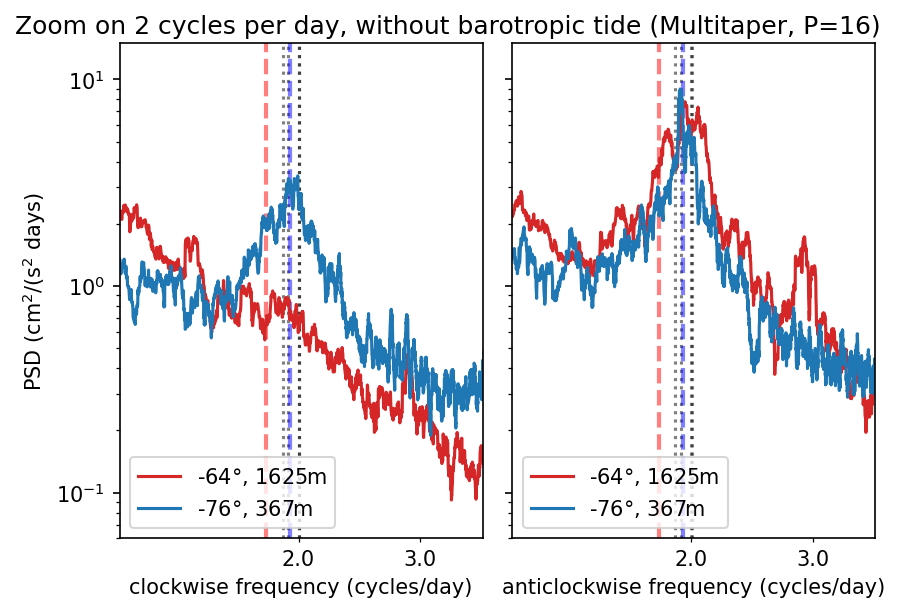

In [19]:
cvs = [ncv,scv]
labels = [f"{nlat:.0f}$\degree$, {ndepth:.0f}m",f"{slat:.0f}$\degree$, {sdepth:.0f}m"]
dt = 2/24
colors = ["tab:red","tab:blue"]


fig, ax = plt.subplots(ncols =2,sharey=True, figsize=(6,4))
    
for i,cv in enumerate(cvs):
    
    cv = cv[~np.isnan(cv)] #remove 
    ccv = cv
    
    errcalc = "wboot"
    out  = tt.t_tide(xin = cv, dt = 2, out_style = None, lat = lats[i], errcalc = errcalc)
    tidal_uv = out["xout"]

    #remove tidal peaks
    cv = cv - tidal_uv.squeeze()
    
    f, _S = sg.periodogram(cv-np.mean(cv), fs=1/dt) #fs = sampling frequency (cyclic)
    
    P = 16
    psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2*P-1)

    Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  

    #print(np.all(np.isnan(cv)))
    
    ax[0].loglog(-f[np.where(f<0)],S[np.where(f<0)], label = labels[i], color = colors[i])#plot negative side
    ax[1].loglog( f[np.where(f>0)],S[np.where(f>0)], label = labels[i], color = colors[i])#plot positive side

    """
    #plot original time series
    Zk, weights, eigenvalues = spectrum.mtm.pmtm(ccv-np.mean(ccv), k=2*P-1,  NFFT=np.size(ccv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  
    ax[0].loglog(-f[np.where(f<0)],S[np.where(f<0)], label = labels[i], color = colors[i], alpha = 0.3)
    """
    
    ax[0].invert_xaxis()
    ax[0].set_ylabel('PSD (cm$^2$/(s$^2$ days)')
    ax[0].set_xlabel('clockwise frequency (cycles/day)')#'Negative Frequency (cycles/day)')


    #ax[1].autoscale(enable=True, tight=True)
    ax[1].set_ylim(0.06, 15) 
    #ax[0].set_xlim(8, 0.2*1e-3)
    #ax[0].set_xlim(0.2*1e-3, 8)
    ax[0].set_xlim(1.1, 3.7)
    ax[1].set_xlim(1.1, 3.7)
    ax[1].set_xlabel('anticlockwise frequency (cycles/day)') #('Positive Frequency (cycles/day)')

ax[0].legend(loc = "lower left")   
ax[1].legend(loc = "lower left") 

for n in range(np.size(ax)):
    #ax[n].autoscale(enable=True, tight=True)
    #[ax[n].axvline(24/_v,linestyle=":", color="black", alpha = 0.5, zorder = -1) for _v in tidal_constit.values()]
    [ax[n].axvline(_x,linestyle=":", color="black", alpha = 0.5, zorder = -1) for _x in tidefreq()/2/np.pi]
    ax[n].axvline(corfreq(nlat)/2/np.pi,linestyle="--", color="red",linewidth=2, alpha = 0.5, zorder = -1)
    ax[n].axvline(corfreq(slat)/2/np.pi,linestyle="--", color="blue",linewidth=2, alpha = 0.5, zorder = -1)  

    io=(1,50,200,800,1600)
    yo=(10**2,10**1,10**0,10**(-0.5),10**(-0.75))
    
    """
    plt.sca(ax[n])
    for i in range(np.size(io)):
        if i==0:
            plt.hlines(yo[i],f[io[i]],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)
        else:
            plt.hlines(yo[i],f[io[i]-P],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)      
    """


from matplotlib.ticker import ScalarFormatter
for axis in [ax[0].xaxis, ax[1].xaxis]:
    axis.set_minor_formatter(ScalarFormatter())

"""
import matplotlib.ticker as ticker
ax[0].xaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:f:.0}'.format(y)))
ax[1].xaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:f:.0}'.format(y)))

for axis in [ax[0].xaxis, ax[1].xaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    #axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)    
"""    
fig.tight_layout()
fig.suptitle('Zoom on 2 cycles per day, without barotropic tide (Multitaper, P=16)', y=1.01);
plt.gcf().patch.set_facecolor('white')
#plt.tight_layout()
plt.savefig("./NS_diff_Zoom",dpi = 200, bbox_inches='tight')   

[0.00188709 0.00377418 0.00566127 ... 5.99528228 5.99716937 5.99905646]
[-0.00188709 -0.00377418 -0.00566127 ... -5.99339519 -5.99528228
 -5.99716937]
[0.00089272 0.00178545 0.00267817 ... 5.99732183 5.99821455 5.99910728]
[-0.00089272 -0.00178545 -0.00267817 ... -5.99732183 -5.99821455
 -5.99910728]


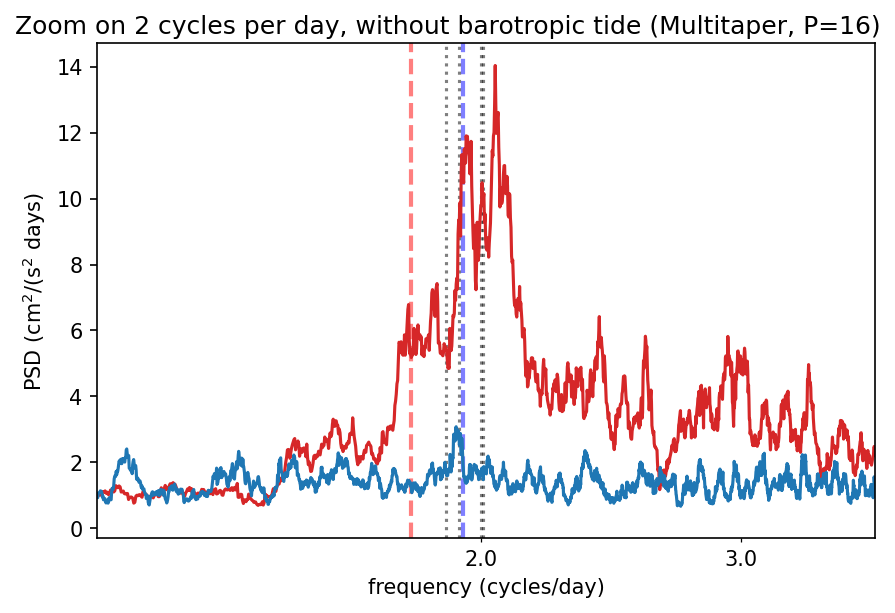

In [35]:
cvs = [ncv,scv]
labels = [f"{nlat:.0f}$\degree$, {ndepth:.0f}m",f"{slat:.0f}$\degree$, {sdepth:.0f}m"]
dt = 2/24
colors = ["tab:red","tab:blue"]


fig, ax = plt.subplots(ncols =1,sharey=True, figsize=(6,4))
    
for i,cv in enumerate(cvs):
    
    cv = cv[~np.isnan(cv)] #remove 
    ccv = cv
    
    errcalc = "wboot"
    out  = tt.t_tide(xin = cv, dt = 2, out_style = None, lat = lats[i], errcalc = errcalc)
    tidal_uv = out["xout"]

    #remove tidal peaks
    cv = cv - tidal_uv.squeeze()
    
    f, _S = sg.periodogram(cv-np.mean(cv), fs=1/dt) #fs = sampling frequency (cyclic)
    
    P = 16
    psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2*P-1)

    Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), k=2*P-1,  NFFT=np.size(cv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  

    #print(np.all(np.isnan(cv)))
    
    #ratio of clockwise/anticlockwise
    print(f[np.where(f>0)])
    print(f[np.where(f<0)][::-1][:-1])
    
    try:
        ratio = S[np.where(f<0)][::-1]/S[np.where(f>0)]
    except ValueError:
        ratio = S[np.where(f<0)][::-1][:-1]/S[np.where(f>0)]
    
    ax.semilogx( f[np.where(f>0)],1/ratio, color = colors[i])#plot positive side

    """
    #plot original time series
    Zk, weights, eigenvalues = spectrum.mtm.pmtm(ccv-np.mean(ccv), k=2*P-1,  NFFT=np.size(ccv), v=psi, e=eigs, method="unity");
    S=np.mean(np.transpose(np.abs(Zk)**2), axis=1) * dt  
    ax[0].loglog(-f[np.where(f<0)],S[np.where(f<0)], label = labels[i], color = colors[i], alpha = 0.3)
    """
    
    ax.invert_xaxis()
    ax.set_ylabel('PSD (cm$^2$/(s$^2$ days)')
    ax.set_xlabel('frequency (cycles/day)')#'Negative Frequency (cycles/day)')


    #ax[1].autoscale(enable=True, tight=True)
    #ax.set_ylim(0.06, 15) 
    #ax[0].set_xlim(8, 0.2*1e-3)
    #ax[0].set_xlim(0.2*1e-3, 8)
    ax.set_xlim(1.1, 3.7)


#ax.legend(loc = "lower left")   

[ax.axvline(_x,linestyle=":", color="black", alpha = 0.5, zorder = -1) for _x in tidefreq()/2/np.pi]
ax.axvline(corfreq(nlat)/2/np.pi,linestyle="--", color="red",linewidth=2, alpha = 0.5, zorder = -1)
ax.axvline(corfreq(slat)/2/np.pi,linestyle="--", color="blue",linewidth=2, alpha = 0.5, zorder = -1)  

io=(1,50,200,800,1600)
yo=(10**2,10**1,10**0,10**(-0.5),10**(-0.75))

"""
plt.sca(ax[n])
for i in range(np.size(io)):
    if i==0:
        plt.hlines(yo[i],f[io[i]],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)
    else:
        plt.hlines(yo[i],f[io[i]-P],f[io[i]+P],linewidth=3,color='k', alpha = 0.2)      
"""


from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.xaxis]:
    axis.set_minor_formatter(ScalarFormatter())

"""
import matplotlib.ticker as ticker
ax[0].xaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:f:.0}'.format(y)))
ax[1].xaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:f:.0}'.format(y)))

for axis in [ax[0].xaxis, ax[1].xaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    #axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)    
"""    
fig.tight_layout()
fig.suptitle('Zoom on 2 cycles per day, without barotropic tide (Multitaper, P=16)', y=1.01);
plt.gcf().patch.set_facecolor('white')
#plt.tight_layout()
#plt.savefig("./NS_diff_Zoom",dpi = 200, bbox_inches='tight')   

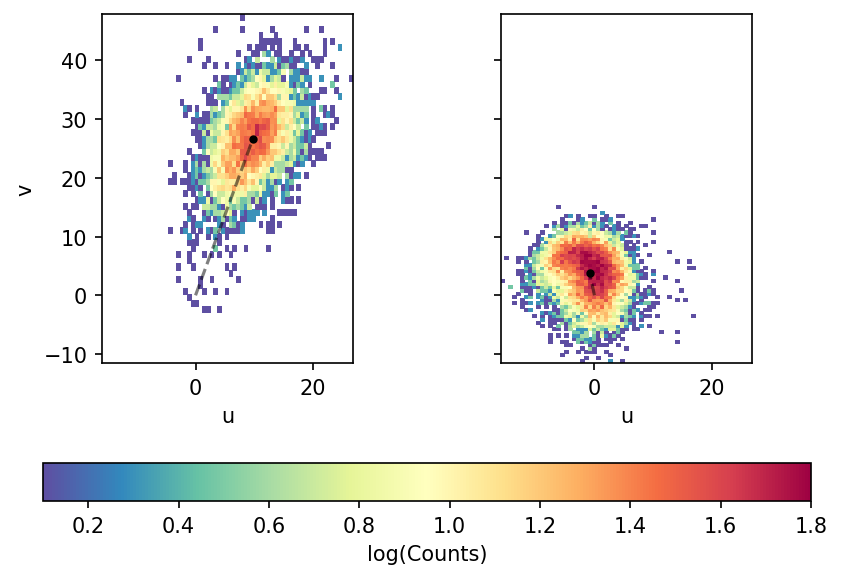

In [76]:
f,a = plt.subplots(ncols = 2, sharex = True, sharey = True)
colors = ["tab:red","tab:blue"]
for i,cv in enumerate(cvs):
    out  = tt.t_tide(xin = cv, dt = 2, out_style = None, lat = lats[i], errcalc = errcalc)
    tidal_uv = out["xout"]
    #remove tidal peaks
    plot_cv = cv - tidal_uv.squeeze()
    #a[i].plot(plot_cv.real,plot_cv.imag, color = colors[i])
    
    u = plot_cv.real 
    v = plot_cv.imag 
    
    ubins = np.linspace(min(u), max(u),50)
    vbins = np.linspace(min(v), max(v),50)
    hist = stats.binned_statistic_2d(u, v, None, bins=[ubins, vbins], statistic="count")  # Returns a object
    #hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf

    cmap = plt.cm.get_cmap("Spectral_r")
    image = a[i].pcolormesh(ubins, vbins, np.log10(hist.statistic.T), cmap = cmap, shading="flat", vmin = 0.1, vmax = 1.8)
    a[i].plot(np.mean(u),np.mean(v),"k.")
    a[i].plot([0,np.mean(u)],[0,np.mean(v)],"k--", alpha = 0.5)
    
    a[i].set_aspect("equal")


a[0].set_xlabel("u")    
a[1].set_xlabel("u")   
a[0].set_ylabel("v")    
    
f.tight_layout()
f.colorbar(image, ax= a.ravel().tolist(), orientation = "horizontal", fraction=0.1, aspect=20, pad=0.2, label= "log(Counts)")
